<a href="https://colab.research.google.com/github/as791/stAdv-PyTorch/blob/main/StAdv_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms,datasets
from scipy import optimize 

from tqdm.notebook import tqdm

##Train Model 

In [45]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=5),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(0.25),
        nn.Linear(64*20*20, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10),
      )

    def forward(self, x):
      return self.model(x)


class NetB(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=8),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Conv2d(64, 128, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=5),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(128*12*12, 10)
    )

  def forward(self, x):
    return self.model(x) 
  

class NetC(nn.Module):
  def __init__(self):
    super().__init__()
    self.model(
      nn.Conv2d(1, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 64, 3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.25),
      nn.Linear(64*24*24, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    return self.model(x)

In [33]:
def fit(model,device,train_loader,val_loader,optimizer,criterion,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  train_acc,val_acc=[],[]
  
  for epoch in tqdm(range(epochs)):
    loss_per_epoch,val_loss_per_epoch=0,0
    acc_per_epoch,val_acc_per_epoch,total,val_total=0,0,0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        inputs,labels  = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        #preding classes of one batch
        preds = torch.max(outputs,1)[1]
        #calculating loss on the output of one batch
        loss = criterion(outputs,labels)
        if phase == 'train':
          acc_per_epoch+=(labels==preds).sum().item()
          total+= labels.size(0)
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_acc_per_epoch+=(labels==preds).sum().item()
          val_total+=labels.size(0)
          val_loss_per_epoch+=loss.item()
    print("Epoch: {} Loss: {:0.6f} Acc: {:0.6f} Val_Loss: {:0.6f} Val_Acc: {:0.6f}".format(epoch+1,loss_per_epoch/len(train_loader),acc_per_epoch/total,val_loss_per_epoch/len(val_loader),val_acc_per_epoch/val_total))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
    train_acc.append(acc_per_epoch/total)
    val_acc.append(val_acc_per_epoch/val_total)
  return train_loss,val_loss,train_acc,val_acc

In [38]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [55000, 5000])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)

device = torch.device("cuda")

model = NetB().to(device)
# summary(model,(1,28,28))

optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

train_loss,val_loss,train_acc,val_acc=fit(model,device,train_loader,val_loader,optimizer,criterion,20)

torch.save(model.state_dict(),'./modelB.pt')

Fitting the model...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.272855 Acc: 0.912636 Val_Loss: 0.100326 Val_Acc: 0.967400
Epoch: 2 Loss: 0.072586 Acc: 0.977491 Val_Loss: 0.066294 Val_Acc: 0.979800
Epoch: 3 Loss: 0.049596 Acc: 0.985018 Val_Loss: 0.058572 Val_Acc: 0.983400
Epoch: 4 Loss: 0.040778 Acc: 0.987727 Val_Loss: 0.054586 Val_Acc: 0.982000
Epoch: 5 Loss: 0.035114 Acc: 0.989309 Val_Loss: 0.050631 Val_Acc: 0.985000
Epoch: 6 Loss: 0.030100 Acc: 0.990527 Val_Loss: 0.058050 Val_Acc: 0.987000
Epoch: 7 Loss: 0.028076 Acc: 0.990618 Val_Loss: 0.041898 Val_Acc: 0.987000
Epoch: 8 Loss: 0.023470 Acc: 0.992073 Val_Loss: 0.044181 Val_Acc: 0.986600
Epoch: 9 Loss: 0.022021 Acc: 0.992727 Val_Loss: 0.035610 Val_Acc: 0.988800
Epoch: 10 Loss: 0.019327 Acc: 0.993600 Val_Loss: 0.045277 Val_Acc: 0.986800
Epoch: 11 Loss: 0.017070 Acc: 0.994945 Val_Loss: 0.040839 Val_Acc: 0.987200
Epoch: 12 Loss: 0.015999 Acc: 0.994927 Val_Loss: 0.034206 Val_Acc: 0.989400
Epoch: 13 Loss: 0.014034 Acc: 0.995782 Val_Loss: 0.038575 Val_Acc: 0.988600
Epoch: 14 Loss: 0.014

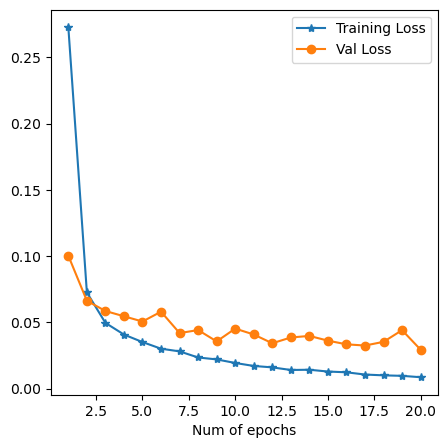

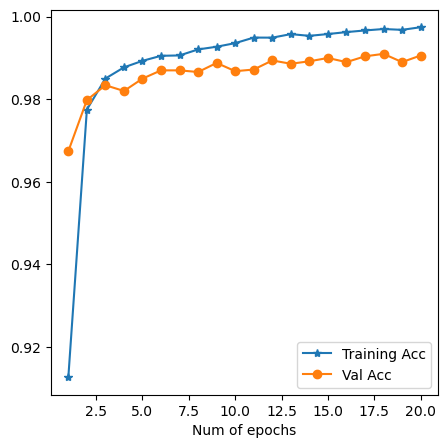

In [40]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), train_loss, "*-",label="Training Loss")
plt.plot(np.arange(1,21), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
# plt.savefig('loss_event.png')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), train_acc, "*-",label="Training Acc")
plt.plot(np.arange(1,21), val_acc,"o-",label="Val Acc")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
# plt.savefig('accuracy_event.png')

##stAdv Attack 

In [25]:
#https://github.com/rakutentech/stAdv - refered code
def flow_st(images,flows):
  images_shape = images.size()
  flows_shape = flows.size()
  batch_size = images_shape[0]
  H = images_shape[2]
  W = images_shape[3]
  basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
  sampling_grid = basegrid.unsqueeze(0).type(torch.float32).cuda() + flows.cuda()
  sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
  sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)

  x0 = torch.floor(sampling_grid_x).type(torch.int64)
  x1 = x0 + 1
  y0 = torch.floor(sampling_grid_y).type(torch.int64)
  y1 = y0 + 1

  x0 = torch.clamp(x0, 0, W - 2)
  x1 = torch.clamp(x1, 0, W - 1)
  y0 = torch.clamp(y0, 0, H - 2)
  y1 = torch.clamp(y1, 0, H - 1)
  
  Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
  Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
  Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
  Id = images[:,:,y1[0,:,:], x1[0,:,:]]

  x0 = x0.type(torch.float32)
  x1 = x1.type(torch.float32)
  y0 = y0.type(torch.float32)
  y1 = y1.type(torch.float32)
  
  wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
  wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
  wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
  wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)
  
  perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id

  return perturbed_image.type(torch.float32).cuda()

In [124]:
def flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2 
  loss=0
  for shifted_flow in shifted_flows:
    #Weird Loss:
    up_uq = torch.square(torch.norm(flows[:, 1] - shifted_flow[:, 1], 2))
    vp_vq = torch.square(torch.norm(flows[:, 0] - shifted_flow[:, 0], 2))

    #This should be the loss but works worse and is slower
    # up_uq = torch.square(flows[:, 1] - shifted_flow[:, 1])
    # vp_vq = torch.square(flows[:, 0] - shifted_flow[:, 0])

    loss += torch.sum(torch.sqrt(up_uq + vp_vq + epsilon)).cuda()

  return loss.type(torch.float32)

def adv_loss(logits,targets,confidence=0.0):
  confidence=torch.tensor(confidence).cuda()
  real = torch.sum(logits*targets,-1)
  other = torch.max((1-targets)*logits-(targets*10000),-1)[0]
  return torch.max(other-real,confidence)[0].type(torch.float32)

In [120]:
def func(flows,input,target,model,const=0.05):
  input = torch.from_numpy(input).cuda()
  target = torch.from_numpy(target).cuda()
  flows = torch.from_numpy(flows).view((1,2,)+input.size()[2:]).cuda()
  flows.requires_grad=True
  pert_out = flow_st(input,flows)
  output = model(pert_out)
  L_flow = flow_loss(flows)
  L_adv = adv_loss(output,target)
  L_final = L_adv+const*L_flow
  model.zero_grad()
  L_final.backward()
  gradient = flows.grad.data.view(-1).detach().cpu().numpy()
  # print(f'{gradient=}')
  return L_final.item(), gradient

In [43]:
def attack(input,target,model):
  init_flows = np.zeros((1,2,)+input.size()[2:]).reshape(-1)

  results = optimize.fmin_l_bfgs_b(func, init_flows, args=(input.cpu().numpy(), target.cpu().numpy(), model))

  if 'CONVERGENCE' in results[2]['task']:
    flows = torch.from_numpy(results[0]).view((1,2,) + input.size()[2:])
    pert_out = flow_st(input,flows)

  else:
    return None
  
  return pert_out

In [121]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model = Net().to(device) 
model.load_state_dict(torch.load('./model.pt'))
model.eval()

adv=[]
adv_label=[]
correct_label=[]
sample=100
success=0
for i,data in tqdm(enumerate(test_loader), total=sample):
  if i<sample:
    input,label = data[0].to(device),data[1].to(device)
    random_target = np.random.choice([num for num in range(10) if num != label.item()])
    target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0)).cuda()
    pert_out = attack(input,target,model)
    if pert_out!=None:
      output =  model(pert_out) 
      adv.append(pert_out.squeeze().detach().cpu().numpy())
      correct_label.append(label.item())
      adv_label.append(torch.argmax(output).item())
      if label.item()!=torch.argmax(output).item():
        success+=1
  else:
    break

  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.7500 


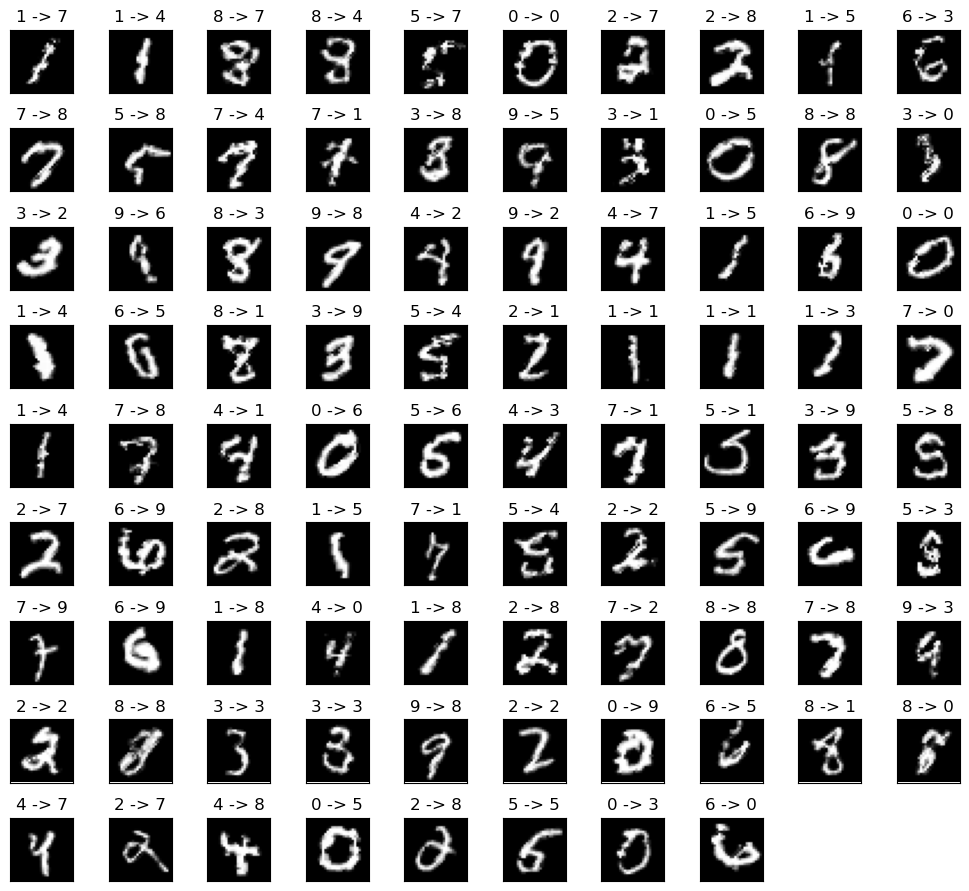

In [123]:
print("Success Rate: {:.4f} ".format(success/sample))
cnt = 0
plt.figure(figsize=(10,10))

for i in range(len(adv)):
  cnt += 1
  plt.subplot(10,10,cnt)
  plt.xticks([], [])
  plt.yticks([], [])
  orig,adv_,ex = correct_label[i],adv_label[i],adv[i]
  plt.title("{} -> {}".format(orig, adv_))
  plt.imshow(ex, cmap="gray")

plt.tight_layout()

plt.savefig("figures/images_weird_modelA.pdf")